In [1]:
%load_ext autoreload 
%autoreload 2

# Exp6 Pretrain Patch GAN to obtain feature extractor (fundus)

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2, Discriminator_128_v2_PatchGAN
from loader import All_fundus_files

In [3]:
# settings
dataroot = "data/celeba"
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 100
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# dataloader
'''
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
'''
train_dataset = All_fundus_files(transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2_PatchGAN(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
#criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [20,60,90], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [20,60,90], gamma=0.1)

41317
41317
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

In [5]:
from torchsummary import summary
summary(net_D, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 7, 7]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 7, 7]               0
        LeakyReLU-14           [-1, 102

In [5]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output = net_D(real_data).view(-1)
        fake_output = net_D(fake_data.detach()).view(-1)
        real_loss_D = criterion(real_output, real_label)
        fake_loss_D = criterion(fake_output, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G = net_D(fake_data).view(-1)
        loss_G = criterion(fake_output_G, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp6/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [6]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/100] Iter:1  Loss_D=1.6579 Loss_G=1.9923 D(x)=0.6136 D(G(z))=0.6902, -0.3731
[0/100] Iter:51  Loss_D=0.5565 Loss_G=0.9372 D(x)=1.2797 D(G(z))=0.4923, -0.0055
[0/100] Iter:101  Loss_D=0.1105 Loss_G=0.9138 D(x)=0.9216 D(G(z))=-0.0169, 0.0013
[0/100] Iter:151  Loss_D=1.1995 Loss_G=0.3002 D(x)=0.8043 D(G(z))=0.0846, 1.4624
[0/100] Iter:201  Loss_D=0.1068 Loss_G=0.5773 D(x)=0.9194 D(G(z))=-0.0698, 0.1866
[0/100] Iter:251  Loss_D=0.6310 Loss_G=2.7440 D(x)=1.2372 D(G(z))=0.8511, -0.6916
[0/100] Iter:301  Loss_D=0.0815 Loss_G=1.3229 D(x)=1.0652 D(G(z))=0.1816, -0.1817
[1/100] Iter:1  Loss_D=0.1762 Loss_G=1.3440 D(x)=1.0535 D(G(z))=0.4980, -0.2009
[1/100] Iter:51  Loss_D=0.2536 Loss_G=0.3732 D(x)=0.9079 D(G(z))=-0.2925, 0.3644
[1/100] Iter:101  Loss_D=0.9839 Loss_G=1.2016 D(x)=0.1587 D(G(z))=0.6511, -0.1526
[1/100] Iter:151  Loss_D=0.2492 Loss_G=0.4534 D(x)=1.2137 D(G(z))=0.4275, 0.3054
[1/100] Iter:201  Loss_D=0.1595 Loss_G=1.5344 D(x)=1.1171 D(G(z))=0.4479, -0.2840
[1/100] Iter:251  Loss_D

[14/100] Iter:201  Loss_D=0.6833 Loss_G=0.4514 D(x)=0.7930 D(G(z))=0.5086, 0.3312
[14/100] Iter:251  Loss_D=0.1909 Loss_G=0.5063 D(x)=0.8438 D(G(z))=0.4872, 0.2563
[14/100] Iter:301  Loss_D=0.4061 Loss_G=0.1367 D(x)=0.3749 D(G(z))=0.0872, 0.6413
[15/100] Iter:1  Loss_D=0.1739 Loss_G=0.4853 D(x)=0.7674 D(G(z))=0.4307, 0.2590
[15/100] Iter:51  Loss_D=0.2113 Loss_G=0.6012 D(x)=0.8758 D(G(z))=0.5505, 0.2103
[15/100] Iter:101  Loss_D=0.2079 Loss_G=0.5367 D(x)=0.7018 D(G(z))=0.4656, 0.2234
[15/100] Iter:151  Loss_D=0.1518 Loss_G=0.5150 D(x)=0.7998 D(G(z))=0.4433, 0.2827
[15/100] Iter:201  Loss_D=0.1971 Loss_G=0.2873 D(x)=0.5837 D(G(z))=0.2837, 0.4310
[15/100] Iter:251  Loss_D=0.6455 Loss_G=2.1486 D(x)=1.2160 D(G(z))=0.8472, -0.4878
[15/100] Iter:301  Loss_D=0.6268 Loss_G=0.2329 D(x)=0.6909 D(G(z))=0.3848, 0.4796
[16/100] Iter:1  Loss_D=0.2683 Loss_G=0.2344 D(x)=0.6601 D(G(z))=0.5221, 0.5160
[16/100] Iter:51  Loss_D=0.2342 Loss_G=0.1755 D(x)=0.5286 D(G(z))=0.1991, 0.5615
[16/100] Iter:101  Lo

[29/100] Iter:1  Loss_D=0.2148 Loss_G=0.1514 D(x)=0.7363 D(G(z))=0.4843, 0.5832
[29/100] Iter:51  Loss_D=0.2832 Loss_G=0.3101 D(x)=0.4738 D(G(z))=0.2614, 0.4431
[29/100] Iter:101  Loss_D=0.7731 Loss_G=0.2866 D(x)=0.7401 D(G(z))=0.3449, 0.4505
[29/100] Iter:151  Loss_D=0.1442 Loss_G=0.4953 D(x)=0.8046 D(G(z))=0.4445, 0.2480
[29/100] Iter:201  Loss_D=0.1719 Loss_G=0.3134 D(x)=0.7147 D(G(z))=0.3974, 0.4365
[29/100] Iter:251  Loss_D=0.2256 Loss_G=0.3798 D(x)=1.0334 D(G(z))=0.5675, 0.3558
[29/100] Iter:301  Loss_D=0.1620 Loss_G=0.4664 D(x)=0.7730 D(G(z))=0.4457, 0.2929
[30/100] Iter:1  Loss_D=0.1685 Loss_G=0.3778 D(x)=0.8010 D(G(z))=0.4684, 0.3603
[30/100] Iter:51  Loss_D=0.2330 Loss_G=0.1777 D(x)=0.5835 D(G(z))=0.3900, 0.5513
[30/100] Iter:101  Loss_D=0.1511 Loss_G=0.3688 D(x)=0.7276 D(G(z))=0.3753, 0.3734
[30/100] Iter:151  Loss_D=0.2918 Loss_G=0.2331 D(x)=0.4898 D(G(z))=0.3086, 0.4975
[30/100] Iter:201  Loss_D=0.2214 Loss_G=0.3214 D(x)=0.5192 D(G(z))=0.2223, 0.3846
[30/100] Iter:251  Los

[43/100] Iter:151  Loss_D=0.1411 Loss_G=0.4666 D(x)=0.8125 D(G(z))=0.4168, 0.2940
[43/100] Iter:201  Loss_D=0.1488 Loss_G=0.5551 D(x)=0.9068 D(G(z))=0.4678, 0.2285
[43/100] Iter:251  Loss_D=0.1613 Loss_G=0.4166 D(x)=0.7295 D(G(z))=0.4007, 0.3182
[43/100] Iter:301  Loss_D=0.8834 Loss_G=0.3606 D(x)=0.6832 D(G(z))=0.1934, 0.3952
[44/100] Iter:1  Loss_D=0.1959 Loss_G=0.3268 D(x)=0.6487 D(G(z))=0.3122, 0.4182
[44/100] Iter:51  Loss_D=0.1946 Loss_G=0.2327 D(x)=0.6029 D(G(z))=0.2355, 0.4964
[44/100] Iter:101  Loss_D=0.1706 Loss_G=0.5693 D(x)=0.9024 D(G(z))=0.5072, 0.2414
[44/100] Iter:151  Loss_D=0.1087 Loss_G=0.5154 D(x)=0.8215 D(G(z))=0.3582, 0.2773
[44/100] Iter:201  Loss_D=0.1006 Loss_G=0.5876 D(x)=0.8928 D(G(z))=0.3759, 0.1868
[44/100] Iter:251  Loss_D=0.2726 Loss_G=0.2190 D(x)=0.5019 D(G(z))=0.1816, 0.5048
[44/100] Iter:301  Loss_D=0.1065 Loss_G=0.5942 D(x)=0.7513 D(G(z))=0.2643, 0.2084
[45/100] Iter:1  Loss_D=0.1163 Loss_G=0.4302 D(x)=0.7228 D(G(z))=0.3110, 0.3183
[45/100] Iter:51  Los

[57/100] Iter:301  Loss_D=0.2275 Loss_G=0.6014 D(x)=0.9804 D(G(z))=0.5667, 0.1765
[58/100] Iter:1  Loss_D=0.0994 Loss_G=0.5504 D(x)=0.9693 D(G(z))=0.3826, 0.2326
[58/100] Iter:51  Loss_D=0.1508 Loss_G=0.3295 D(x)=0.6655 D(G(z))=0.2610, 0.3816
[58/100] Iter:101  Loss_D=1.0925 Loss_G=0.5791 D(x)=0.9986 D(G(z))=0.3731, 0.2090
[58/100] Iter:151  Loss_D=0.0817 Loss_G=0.4482 D(x)=0.7826 D(G(z))=0.2182, 0.3178
[58/100] Iter:201  Loss_D=0.1022 Loss_G=0.5568 D(x)=0.8868 D(G(z))=0.3781, 0.2096
[58/100] Iter:251  Loss_D=0.1268 Loss_G=0.3076 D(x)=0.6752 D(G(z))=0.2007, 0.4026
[58/100] Iter:301  Loss_D=0.1006 Loss_G=0.5144 D(x)=0.8199 D(G(z))=0.3248, 0.2537
[59/100] Iter:1  Loss_D=0.1174 Loss_G=0.4478 D(x)=0.7089 D(G(z))=0.2564, 0.2821
[59/100] Iter:51  Loss_D=0.0686 Loss_G=0.5460 D(x)=0.8626 D(G(z))=0.2729, 0.2149
[59/100] Iter:101  Loss_D=0.1112 Loss_G=0.4843 D(x)=0.7229 D(G(z))=0.2900, 0.2829
[59/100] Iter:151  Loss_D=0.1564 Loss_G=0.2816 D(x)=0.6747 D(G(z))=0.3548, 0.4394
[59/100] Iter:201  Los

[72/100] Iter:101  Loss_D=0.0684 Loss_G=0.4718 D(x)=0.9418 D(G(z))=0.3150, 0.2825
[72/100] Iter:151  Loss_D=0.0594 Loss_G=0.6015 D(x)=0.8308 D(G(z))=0.1883, 0.1991
[72/100] Iter:201  Loss_D=0.1161 Loss_G=0.3680 D(x)=0.7091 D(G(z))=0.3274, 0.3334
[72/100] Iter:251  Loss_D=0.0464 Loss_G=0.5730 D(x)=0.9224 D(G(z))=0.2131, 0.1938
[72/100] Iter:301  Loss_D=0.1433 Loss_G=0.3677 D(x)=0.7298 D(G(z))=0.3776, 0.3825
[73/100] Iter:1  Loss_D=0.0956 Loss_G=0.4842 D(x)=0.7643 D(G(z))=0.2726, 0.2741
[73/100] Iter:51  Loss_D=0.0734 Loss_G=0.4400 D(x)=0.8412 D(G(z))=0.3182, 0.2916
[73/100] Iter:101  Loss_D=0.0928 Loss_G=0.4202 D(x)=0.8558 D(G(z))=0.3311, 0.3081
[73/100] Iter:151  Loss_D=0.1098 Loss_G=0.3588 D(x)=0.8730 D(G(z))=0.4270, 0.3856
[73/100] Iter:201  Loss_D=0.0587 Loss_G=0.4933 D(x)=0.9465 D(G(z))=0.2762, 0.2724
[73/100] Iter:251  Loss_D=0.0826 Loss_G=0.5896 D(x)=0.7772 D(G(z))=0.1894, 0.2092
[73/100] Iter:301  Loss_D=0.1070 Loss_G=0.3357 D(x)=0.9312 D(G(z))=0.4060, 0.3731
[74/100] Iter:1  Lo

[86/100] Iter:251  Loss_D=0.0554 Loss_G=0.5944 D(x)=0.8247 D(G(z))=0.2162, 0.2083
[86/100] Iter:301  Loss_D=0.0647 Loss_G=0.5822 D(x)=0.8016 D(G(z))=0.2123, 0.2260
[87/100] Iter:1  Loss_D=0.0723 Loss_G=0.4529 D(x)=0.9203 D(G(z))=0.3201, 0.2877
[87/100] Iter:51  Loss_D=0.1586 Loss_G=0.3222 D(x)=0.7355 D(G(z))=0.3971, 0.4192
[87/100] Iter:101  Loss_D=0.0571 Loss_G=0.5384 D(x)=0.8521 D(G(z))=0.2357, 0.2422
[87/100] Iter:151  Loss_D=0.1769 Loss_G=0.3794 D(x)=0.6514 D(G(z))=0.3388, 0.3601
[87/100] Iter:201  Loss_D=0.0983 Loss_G=0.4136 D(x)=0.9158 D(G(z))=0.3936, 0.3489
[87/100] Iter:251  Loss_D=0.0753 Loss_G=0.4666 D(x)=0.7846 D(G(z))=0.2801, 0.2858
[87/100] Iter:301  Loss_D=0.0753 Loss_G=0.5272 D(x)=0.7833 D(G(z))=0.2229, 0.2427
[88/100] Iter:1  Loss_D=0.0866 Loss_G=0.4174 D(x)=0.8418 D(G(z))=0.3384, 0.3246
[88/100] Iter:51  Loss_D=0.0605 Loss_G=0.4922 D(x)=0.9408 D(G(z))=0.2889, 0.2724
[88/100] Iter:101  Loss_D=0.0695 Loss_G=0.4889 D(x)=0.8571 D(G(z))=0.2934, 0.2811
[88/100] Iter:151  Los

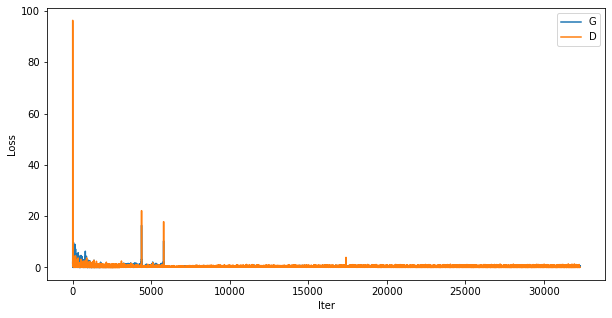

In [7]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

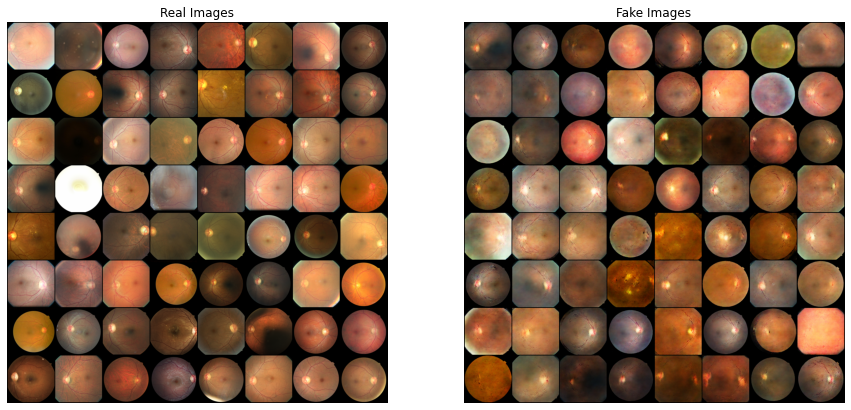

In [8]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()

In [9]:
#Save
state = {
    'net': net_D.state_dict(),
    'acc': 0,
    'epoch': num_epochs,
}
if not os.path.isdir('checkpoint/exp6'):
    os.mkdir('checkpoint/exp6')
torch.save(state, './checkpoint/exp6/ckpt2.pth')